In [2]:
import os
os.chdir("/users/eleves-a/2022/yasser.alghouass/yqssine/learning_tetris/game_code")
from game_simulation import *
import concurrent.futures
import matplotlib.pyplot as plt

### I. Introduction

$\bullet$ Firstly, we have configured the Tetris game, as depicted in `game_code`. The pivotal piece of code is `game_simulation`, which takes a vector $w$ as input. This vector governs the `value_function`, thereby facilitating action selection in Tetris.

$\bullet$ The `value_function` is defined by $V(w)=\sum_{i=1}^{10} w_{i}h_{i} + \sum_{i=1}^{9} w_{i+10}$ $\Delta$  $h_{i}$ $+w_{20}H+w_{21}M$
with $h_{p}$ for $p$ $\in$ $\{1, 2, \ldots, n\}$ is height of the pth column of the board, $\Delta$  $h_{p}=h_{p+1}-h_{p}$, $H$ is the number of empty cells covered by at least one full cell and $M$ is the maximum pile height: $max_{p} h_{p}$. Therefore, for each new piece, we drop the piece with the position that minimize this function.

$\bullet$ Henceforth, from this, we want to maximize the score of a Tetris game. A game is random, so the problem is :
$max_{w} \mathbb{E}(S(w))$ with S the score function.

$\bullet$ Thus, to solve numerically this problem, we implement 2 main methods, cross entropy method and simulated annealing.


### II. Cross entropy method

[Have a look at this following link to see the theoretical aspect of the cross entropy method.](https://people.smp.uq.edu.au/DirkKroese/ps/CEopt.pdf)


Iteration 1: Average score of best samples: 2.6
Iteration 2: Average score of best samples: 6.6
Iteration 3: Average score of best samples: 8.0
Iteration 4: Average score of best samples: 10.5
Iteration 5: Average score of best samples: 15.9
Iteration 6: Average score of best samples: 13.2
Iteration 7: Average score of best samples: 17.5
Iteration 8: Average score of best samples: 23.6
Iteration 9: Average score of best samples: 23.4
Iteration 10: Average score of best samples: 18.9
Iteration 11: Average score of best samples: 23.4
Iteration 12: Average score of best samples: 24.9
Iteration 13: Average score of best samples: 23.1
Iteration 14: Average score of best samples: 20.1
Iteration 15: Average score of best samples: 25.3
Iteration 16: Average score of best samples: 24.8
Iteration 17: Average score of best samples: 20.6
Iteration 18: Average score of best samples: 19.7
Iteration 19: Average score of best samples: 24.9
Iteration 20: Average score of best samples: 24.8
Iteration 21

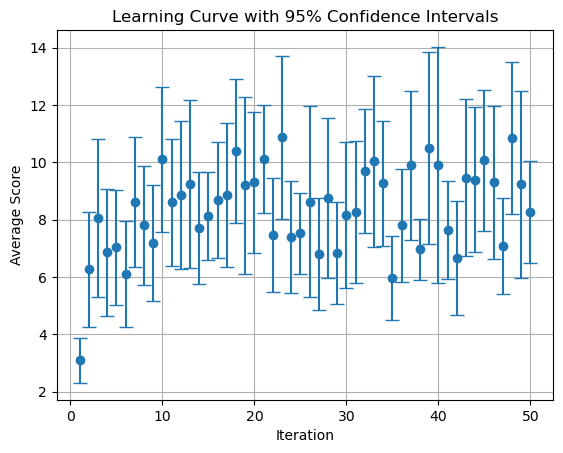

In [3]:
# Number of samples
N = 100
# Proportion of best samples to select
rho = 0.1
# Number of iterations
iterations = 50
# Number of games to play to compute the learning curve
num_games = 30

# Initialize the parameter vector w to zero
w = np.zeros(21)
# Initialize the covariance matrix Sigma to 100 * I
Sigma = 100 * np.eye(21)

learning_curve = []
std=[]
for t in range(iterations):
    # Generate samples from the current Gaussian distribution
    samples = np.random.multivariate_normal(w, Sigma, N)
    
    # Evaluate each sample with the score function (game simulation)
    scores = np.array([simulation(sample) for sample in samples])
    
    # Sort samples based on their score and select the best ones
    best_samples_indices = np.argsort(scores)[-int(N * rho):]
    best_samples = samples[best_samples_indices]
    
    # Update w with the empirical mean of the selected best samples
    w = np.mean(best_samples, axis=0)
    
    # Update Sigma with the empirical covariance of the selected best samples
    Sigma = np.cov(best_samples, rowvar=False)

    # Compute the learning curve with the mean weights of the new distribution
    # Play num_games games with these mean weights and record the scores
    game_scores = [simulation(w) for _ in range(num_games)]
    std.append(np.std(game_scores))
    learning_curve.append(np.mean(game_scores))

    # Print the average score of the best samples at each iteration
    print("Iteration {}: Average score of best samples: {}".format(t+1, np.mean(scores[best_samples_indices])))

# Plot the learning curve
# Plot the learning curve with confidence intervals
plt.errorbar(range(1, iterations+1), learning_curve, yerr=1.96 * (np.array(std) / np.sqrt(num_games)), fmt='o', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('Average Score')
plt.title('Learning Curve with 95% Confidence Intervals')
plt.grid(True)
plt.show()



In [6]:
# Number of samples
N = 100
# Proportion of best samples to select
rho = 0.1
# Number of iterations
iterations = 50
# Number of games to play to compute the learning curve
num_games = 30

def Noisy_CE (iterations=50,N=100,rho=0.1,num_games=30,noise=0):
          # Initialize the parameter vector w to zero
          w = np.zeros(21)
          # Initialize the covariance matrix Sigma to 100 * I
          Sigma = 100 * np.eye(21)

          learning_curve =[]

          for t in range(iterations):
            # Generate samples from the current Gaussian distribution
            samples = np.random.multivariate_normal(w, Sigma, N)

            # Evaluate each sample with the score function (game simulation)
            scores = np.array([simulation(sample) for sample in samples])

            # Sort samples based on their score and select the best ones
            best_samples_indices = np.argsort(scores)[-int(N * rho):]
            best_samples = samples[best_samples_indices]

            # Update w with the empirical mean of the selected best samples
            w = np.mean(best_samples, axis=0)

            # Update Sigma with the empirical covariance of the selected best samples
            Sigma = np.cov(best_samples, rowvar=False)+noise*np.eye(21)

            # Compute the learning curve with the mean weights of the new distribution
            # Play num_games games with these mean weights and record the scores
            game_scores = [simulation(w) for _ in range(num_games)] #parallelizable 
            learning_curve.append(np.mean(game_scores))

            # Print the average score of the best samples at each iteration
            print("Iteration {}: Average score of best samples: {}".format(t+1, np.mean(scores[best_samples_indices])))
          return ((learning_curve))

Iteration 1: Average score of best samples: 0.9
Iteration 11: Average score of best samples: 7.6
Iteration 21: Average score of best samples: 102.4
Iteration 31: Average score of best samples: 632.1
Iteration 41: Average score of best samples: 2288.2


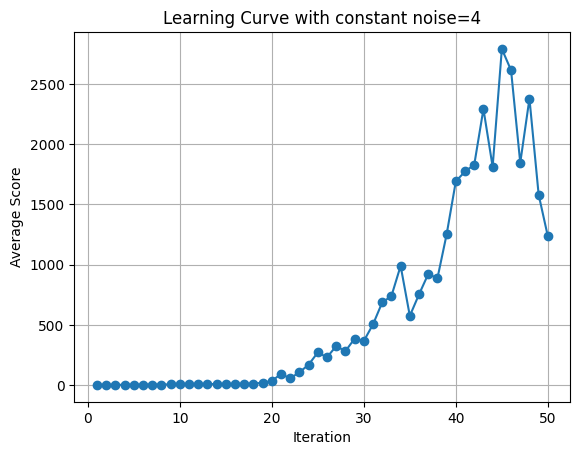

In [7]:
plt.plot(range(1, iterations+1),Noisy_CE(50,100,0.1,30,noise=4), marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Score')
plt.title('Learning Curve with constant noise=4')
plt.grid(True)
plt.show()

Now we will try a linear time decreasing noise function to perturbate the variance of the best sample vectors.


In [24]:
#chosen w.r.t the paper 
a=5
b=10 

def  decr_NCE (iterations=15,N=100,rho=0.1,a=0,b=1):
  noise=lambda t: max((iterations - t)/b, 0)
  # Initialize the parameter vector w to zero
  w = np.zeros(21)
  # Initialize the covariance matrix Sigma to 100 * I
  Sigma = 100 * np.eye(21)

  learning_curve =[]

  for t in range(iterations):
    # Generate samples from the current Gaussian distribution
    samples = np.random.multivariate_normal(w, Sigma, N)

    # Evaluate each sample with the score function (game simulation)
    scores = np.array([simulation(sample) for sample in samples])

    # Sort samples based on their score and select the best ones
    best_samples_indices = np.argsort(scores)[-int(N * rho):]
    best_samples = samples[best_samples_indices]

    # Update w with the empirical mean of the selected best samples
    w = np.mean(best_samples, axis=0)

    # Update Sigma with the empirical covariance of the selected best samples and the  noise function
    Sigma = np.cov(best_samples, rowvar=False)+noise(t)*np.eye(21)

    # Compute the learning curve with the mean weights of the new distribution
    # Play num_games games with these mean weights and record the scores
    with concurrent.futures.ProcessPoolExecutor(max_workers=11) as executor:
       future_games = [executor.submit(simulation, w) for _ in range(num_games)]
       game_scores = [future.result() for future in concurrent.futures.as_completed(future_games)]

    learning_curve.append(np.mean(game_scores))

    # Print the average score of the best samples at each iteration
    if t%10==0 :
        print("Iteration {}: Average score of best samples: {}".format(t+1, np.mean(scores[best_samples_indices])))
  return ((learning_curve))

Iteration 1: Average score of best samples: 1.3
Iteration 11: Average score of best samples: 138.3


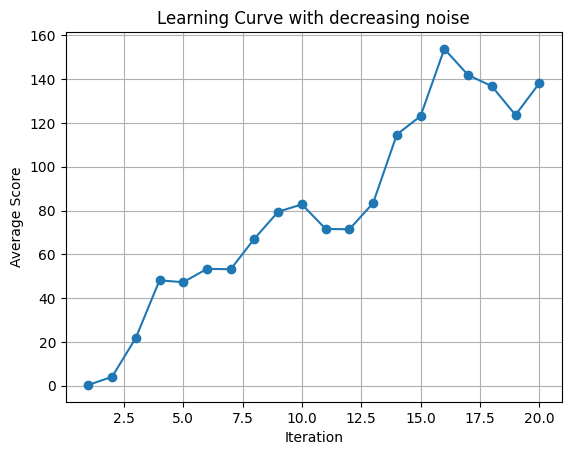

In [27]:
plt.plot(range(1, 21),decr_NCE (20,100,0.1,5,10), marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Score')
plt.title('Learning Curve with decreasing noise')
plt.grid(True)
plt.show()

### Conclusion 

